# Planners
This shows how a variety of planners work on the same data, with the same prediction model.

In [1]:
from ipp_toolkit.planners.masked_planner import RandomMaskedPlanner, LawnmowerMaskedPlanner
from ipp_toolkit.planners.diversity_planner import BatchDiversityPlanner
from ipp_toolkit.data.domain_data import SafeForestGMapGreennessRegressionData
from ipp_toolkit.predictors.uncertain_predictors import GaussianProcessRegression
from ipp_toolkit.predictors.masked_image_predictor import (
    UncertainMaskedLabeledImagePredictor,
)
from ipp_toolkit.visualization.visualization import visualize_prediction

from ipp_toolkit.config import UNCERTAINTY_KEY

/home/frc-ag-1/anaconda3/envs/ipp-toolkit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create a dataset.

In [2]:
data = SafeForestGMapGreennessRegressionData()

# Lawnmower planner
Takes samples on a grid, moving from left to right, top to bottom

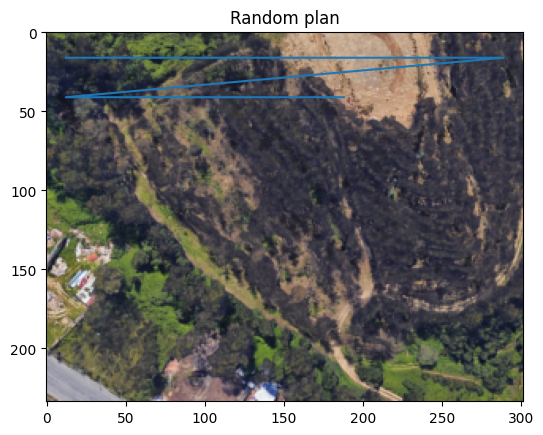

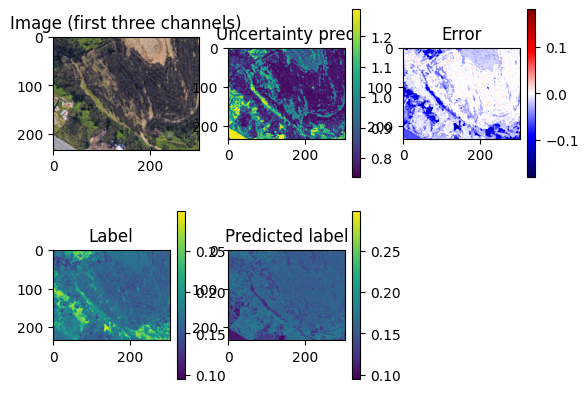

In [3]:
planner = LawnmowerMaskedPlanner(data, n_total_samples=100)
gp = GaussianProcessRegression()
predictor = UncertainMaskedLabeledImagePredictor(
    data, gp, classification_task=data.is_classification_dataset()
)

plan = planner.plan(20, vis=True)
values = data.sample_batch(plan)
predictor.update_model(plan, values)
prediction = predictor.predict_values_and_uncertainty()

visualize_prediction(data, prediction=prediction, predictor=predictor)

### Random planner
The random planner selects a set of random locations to visit, within the valid region of the image.

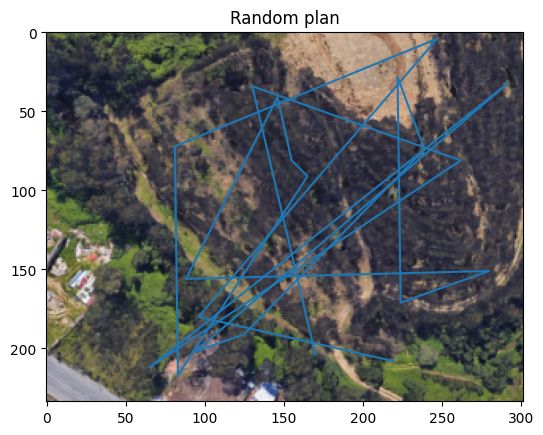

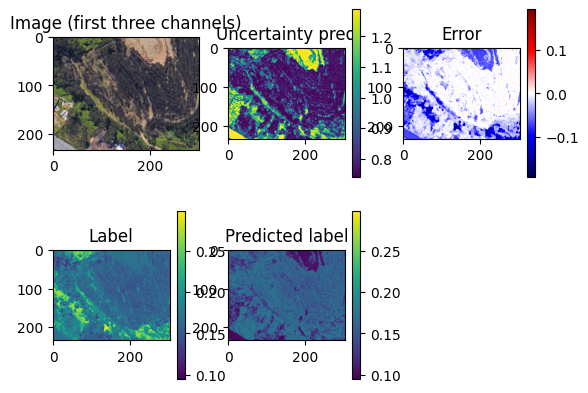

In [4]:


planner = RandomMaskedPlanner(data)
gp = GaussianProcessRegression()
predictor = UncertainMaskedLabeledImagePredictor(
    data, gp, classification_task=data.is_classification_dataset()
)

plan = planner.plan(20, vis=True)
values = data.sample_batch(plan)
predictor.update_model(plan, values)
prediction = predictor.predict_values_and_uncertainty()

visualize_prediction(data, prediction=prediction, predictor=predictor)


### Diversity-based planner
This planner tries to sample a diverse set of locations at each flight. On flights where it has a metric for which regions are most interesting, it also tries to jointly optimize for visiting those regions.

Flight 1


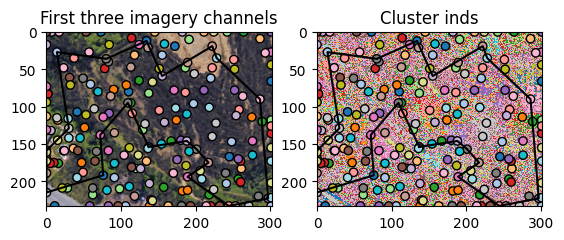

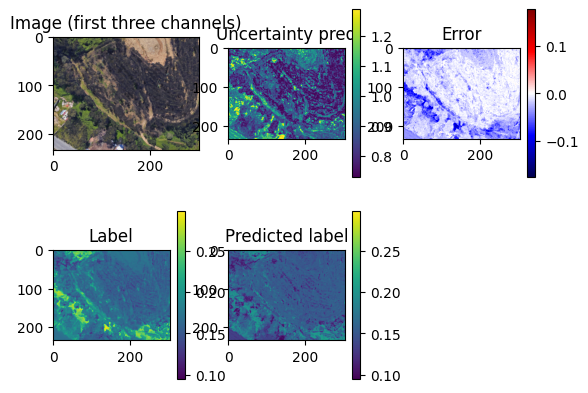

Flight #2


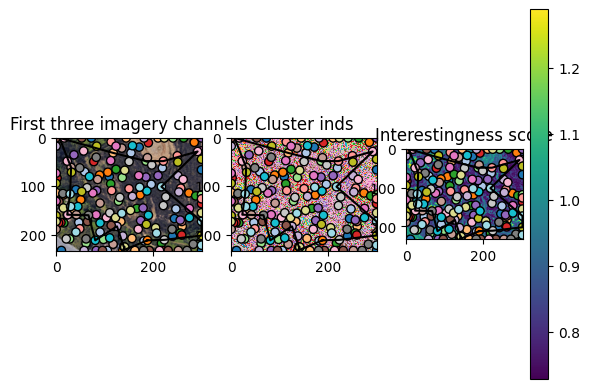

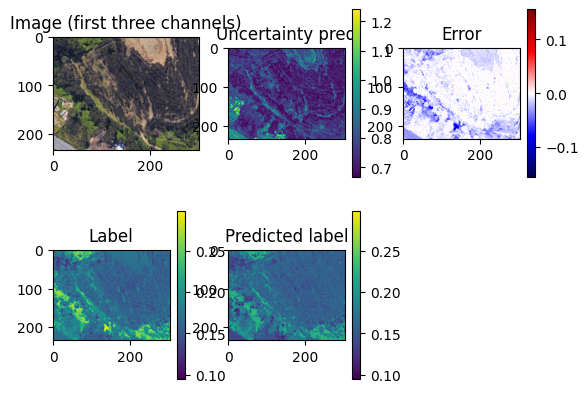

Flight #3


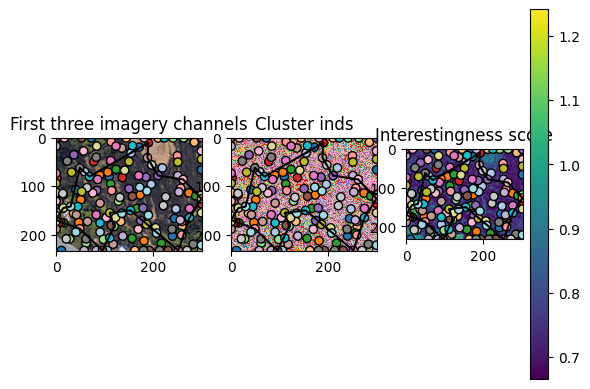

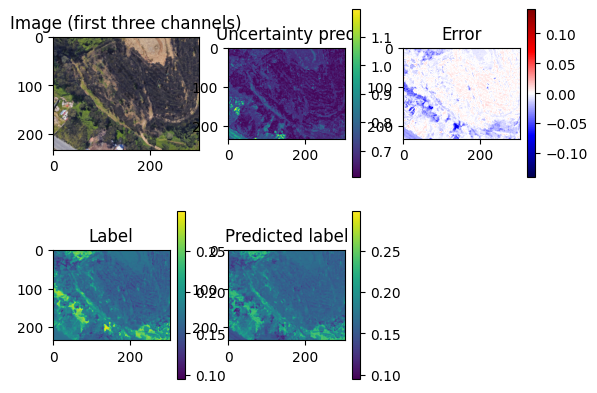

Flight #4


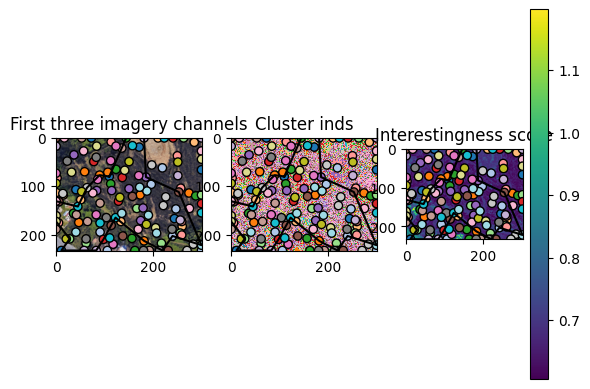

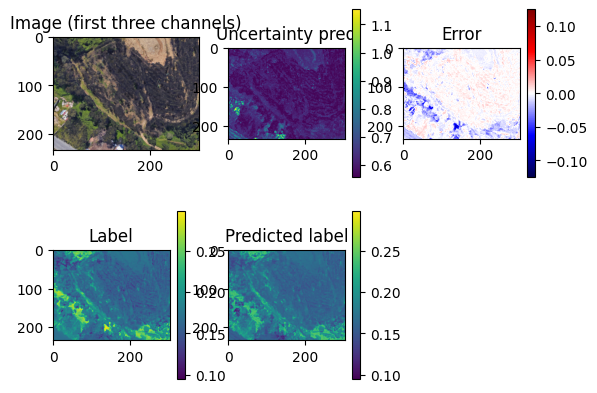

In [5]:
planner = BatchDiversityPlanner(data, n_candidate_locations=200)
gp = GaussianProcessRegression()
predictor = UncertainMaskedLabeledImagePredictor(
    data, gp, classification_task=data.is_classification_dataset()
)

print("Flight 1")
plan = planner.plan(visit_n_locations=20)
values = data.sample_batch(plan)
predictor.update_model(plan, values)
prediction = predictor.predict_values_and_uncertainty()
visualize_prediction(data, prediction=prediction, predictor=predictor)

for i in range(3):
    print(f"Flight #{i+2}")
    interestingness_image = prediction[UNCERTAINTY_KEY]
    plan = planner.plan(interestingness_image=interestingness_image, visit_n_locations=20)
    values = data.sample_batch(plan)
    predictor.update_model(plan, values)
    prediction = predictor.predict_values_and_uncertainty()
    visualize_prediction(data, prediction=prediction, predictor=predictor)